# Gold Standards

In [1]:
# Get packages
using CSV, DataFrames, wgregseq, CairoMakie, Statistics, DelimitedFiles, Dates, Colors, FASTX, BioSequences, StatsBase, ProgressMeter

# Set colors and plotting style
wgregseq.plotting_style.default_makie!()
update_theme!(Theme(font = "Lato", titlefont="Lato"))
colors_dict = wgregseq.plotting_style.my_color_dict
colors = [colors_dict["blue1"], colors_dict["orange1"], colors_dict["green1"]]

3-element Vector{String}:
 "#324fa2"
 "#f47c20"
 "#a8cf38"

In [20]:
df_standards = CSV.read("../../../data/gold_standards.csv", DataFrame)

Row,TU_ID,promoter_ID,genes,direction,promoter,tss,evidence
,String15,String15,String,String1,String7?,Float64,String
1,TU0-13333,none,"[""rspB"", ""rspA""]",-,missing,NaN,"[""None""]"
2,TU00214,PM00003,"[""araB"", ""araA"", ""araD""]",-,araBp,70075.0,"Any[""COMP"", ""EXP""]"
3,TU0-4604,PM0-4844,"[""znuB"", ""znuC""]",+,znuCp,1.94263e6,"Any[""COMP"", ""EXP""]"
4,TU67,PM68,"[""xylB"", ""xylA""]",-,xylAp,3.73081e6,"Any[""none"", ""EXP""]"
5,TU00374,PM70,"[""xylF"", ""xylG"", ""xylH"", ""xylR""]",+,xylFp,3.73107e6,"Any[""none"", ""EXP""]"
6,TU0-13327,PM0-46242,"[""ydfX"", ""ydfW"", ""dicC""]",-,dicCp,1.64788e6,"Any[""none"", ""COMP"", ""EXP""]"
7,TU0-14381,PM0-9527,"[""relB"", ""relE"", ""hokD""]",-,relBp,1.6459e6,"Any[""COMP"", ""EXP""]"
8,TU0-13325,none,"[""relB"", ""relE""]",-,missing,NaN,"[""None""]"
9,TU0-14447,PM0-9680,"[""ftsK""]",+,ftsKp1,933138.0,"Any[""COMP"", ""EXP"", ""COMP""]"


In [136]:
df_sites = CSV.read("known_sites.txt", DataFrame)
df_sites.promoter |> unique

13-element Vector{String7}:
 "rspAp"
 "znuCp"
 "xylAp"
 "xylFp"
 "relBp"
 "ftsKp1"
 "marRp"
 "dgoRp"
 "ompRp1"
 "ompRp2"
 "ompRp4"
 "araBp"
 "araCp"

## Mutual Information

In [102]:
function get_dataset(i)
    df_DNA = CSV.read(
        "../../../data/extracted_barcodes/20230907_barcode/D$(i)_collapsed.txt", 
        DataFrame, 
        ignorerepeated=true, 
        delim=" ", 
        header=["ct_0", "barcode"]
    )
    # import RNA
    df_RNA = CSV.read(
        "../../../data/extracted_barcodes/20230907_barcode/R$(i)_collapsed.txt", 
        DataFrame, 
        ignorerepeated=true, 
        delim=" ", 
        header=["ct_1", "barcode"]
    )
    
    # merge DNA and RNA reads
    df = outerjoin(df_DNA, df_RNA, on=:barcode)
    
    # replace missing reads with 0
    replace!(df.ct_0, missing => 0)
    replace!(df.ct_1, missing => 0)
    
    # identify promoter sequences
    df = innerjoin(df, df_map, on=:barcode)
    
    # compute total counts
    insertcols!(df, 1, :ct => df.ct_0 .+ df.ct_1)
    insertcols!(df, 1, :relative_counts => (df.ct_1 .+ 1) ./ (df.ct_0 .+ 1))
    
    # Turn sequences into integer
    insertcols!(df, 3, :int_promoter => wgregseq.footprints.make_int.(df[:, :promoter]))
    insertcols!(df, 3, :int_wt => wgregseq.footprints.make_int.(df[:, :wt_seq]));
    return df
end

get_dataset (generic function with 1 method)

### rspA

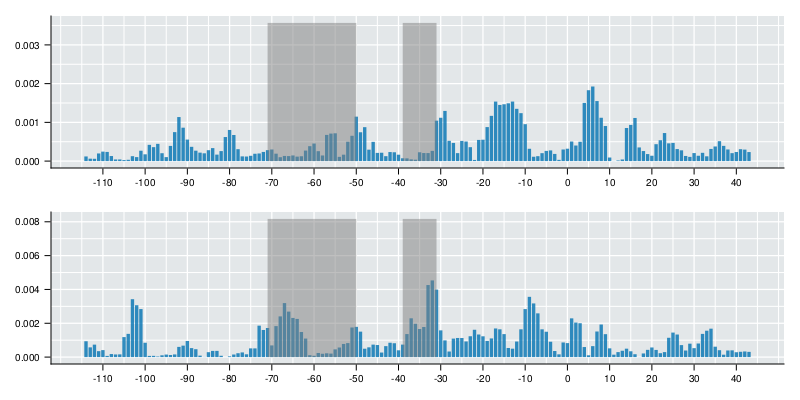

In [103]:
df = get_dataset(1)

df_elife = CSV.read("../../../data/regseq_elife/datasets/rspAM9dataset_alldone_with_large", DataFrame, ignorerepeated=true, delim=" ")
df_elife[!, "seq"] = [x[1:160] for x in df_elife.seq]
rename!(df_elife, :seq => :promoter)
insertcols!(df_elife, 4, :wt_seq => df_map[df_map.name .== "rspAp", :wt_seq][1])
x1 = wgregseq.footprints.mutual_information_mutation(df_elife)

fig = Figure(resolution=(800, 400))
ax1 = Axis(fig[1, 1], xticks=-110:10:40)
d = 1
barplot!(ax1, -115+d:44-d, [mean(x1[i-d:i+d]) for i in 1+d:160-d])

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "rspAp", :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== "rspAp", :])
    band!(ax1, [site["start"], site["end"]], [0, 0], [maximum(x1), maximum(x1)], color=("gray", 0.5))
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end
fig

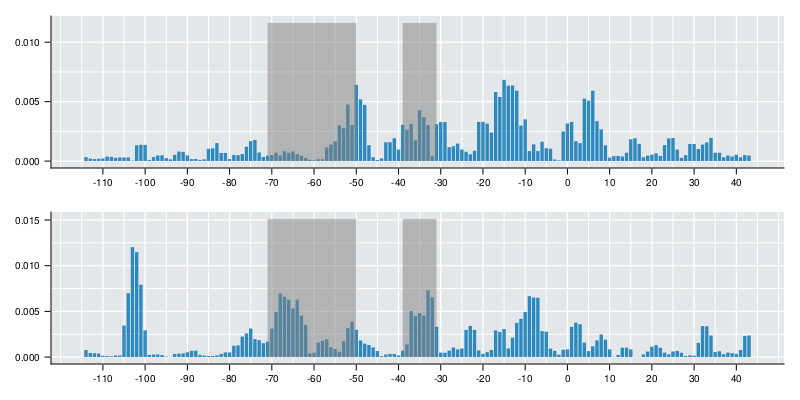

In [104]:
df = get_dataset(13)

df_elife = CSV.read("../../../data/regseq_elife/datasets/rspALBdataset_alldone_with_large", DataFrame, ignorerepeated=true, delim=" ")
df_elife[!, "seq"] = [x[1:160] for x in df_elife.seq]
rename!(df_elife, :seq => :promoter)
insertcols!(df_elife, 4, :wt_seq => df_map[df_map.name .== "rspAp", :wt_seq][1])
x1 = wgregseq.footprints.mutual_information_mutation(df_elife)

fig = Figure(resolution=(800, 400))
ax1 = Axis(fig[1, 1], xticks=-110:10:40)
d = 1
barplot!(ax1, -115+d:44-d, [mean(x1[i-d:i+d]) for i in 1+d:160-d])

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "rspAp", :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== "rspAp", :])
    band!(ax1, [site["start"], site["end"]], [0, 0], [maximum(x1), maximum(x1)], color=("gray", 0.5))
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end
fig

### araBp

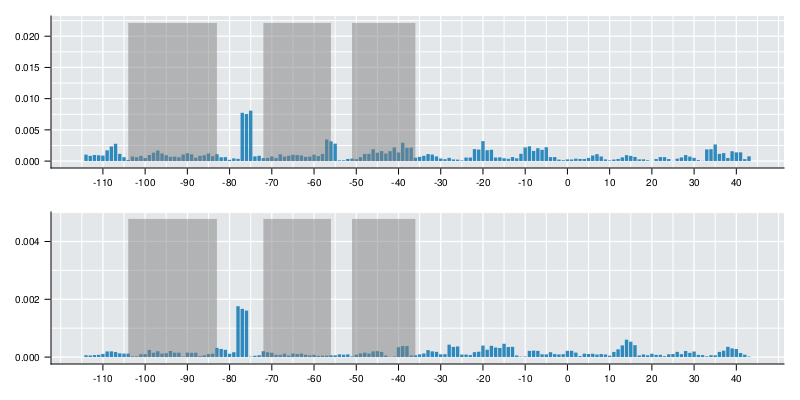

In [105]:
df = get_dataset(1)

df_elife = CSV.read("../../../data/regseq_elife/datasets/araABM9dataset_alldone_with_large", DataFrame, ignorerepeated=true, delim=" ")
df_elife[!, "seq"] = [x[1:160] for x in df_elife.seq]
rename!(df_elife, :seq => :promoter)
insertcols!(df_elife, 4, :wt_seq => df_map[df_map.name .== "araBp", :wt_seq][1])
x1 = wgregseq.footprints.mutual_information_mutation(df_elife)

fig = Figure(resolution=(800, 400))
ax1 = Axis(fig[1, 1], xticks=-110:10:40)
d = 1
barplot!(ax1, -115+d:44-d, [mean(x1[i-d:i+d]) for i in 1+d:160-d])

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "araBp", :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== "araBp", :])
    band!(ax1, [site["start"], site["end"]], [0, 0], [maximum(x1), maximum(x1)], color=("gray", 0.5))
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end
fig

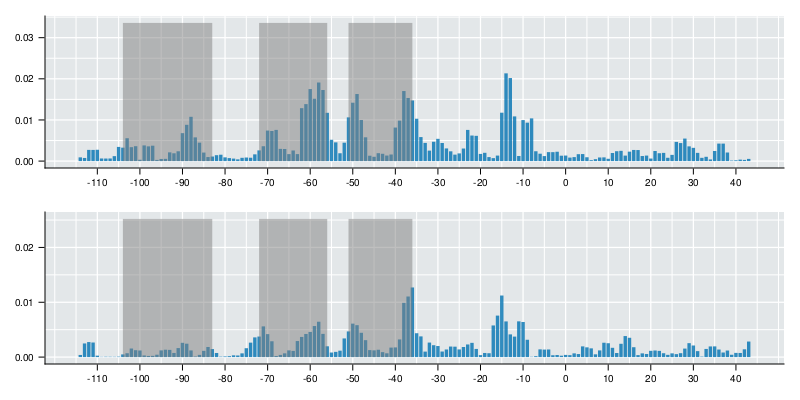

In [142]:
df = get_dataset(3)

df_elife = CSV.read("../../../data/regseq_elife/datasets/araABxylaradataset_alldone_with_large", DataFrame, ignorerepeated=true, delim=" ")
df_elife[!, "seq"] = [x[1:160] for x in df_elife.seq]
rename!(df_elife, :seq => :promoter)
insertcols!(df_elife, 4, :wt_seq => df_map[df_map.name .== "araBp", :wt_seq][1])
x1 = wgregseq.footprints.mutual_information_mutation(df_elife)

fig = Figure(resolution=(800, 400))
ax1 = Axis(fig[1, 1], xticks=-110:10:40)
d = 1
barplot!(ax1, -115+d:44-d, [mean(x1[i-d:i+d]) for i in 1+d:160-d])

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "araBp", :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== "araBp", :])
    band!(ax1, [site["start"], site["end"]], [0, 0], [maximum(x1), maximum(x1)], color=("gray", 0.5))
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end
fig

### znuC

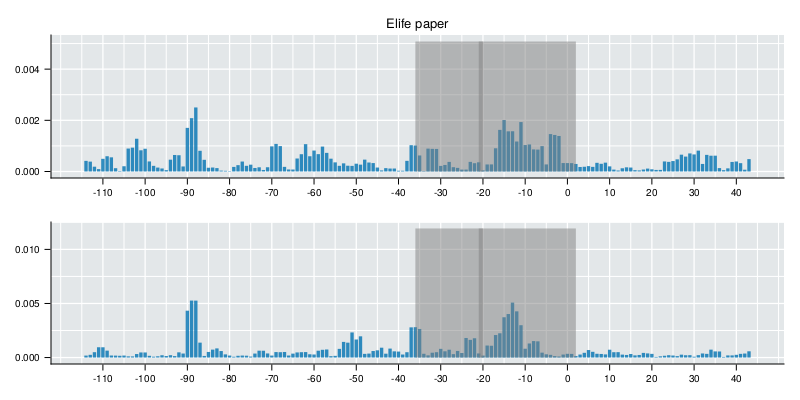

In [76]:
df = get_dataset(1)

df_elife = CSV.read("../../../data/regseq_elife/datasets/znuCBAnaerodataset_alldone_with_large", DataFrame, ignorerepeated=true, delim=" ")
df_elife[!, "seq"] = [x[1:160] for x in df_elife.seq]
rename!(df_elife, :seq => :promoter)
insertcols!(df_elife, 4, :wt_seq => df_map[df_map.name .== "znuCp", :wt_seq][1])
x1 = wgregseq.footprints.mutual_information_mutation(df_elife)

fig = Figure(resolution=(800, 400))
ax1 = Axis(fig[1, 1], xticks=-110:10:40, title="Elife paper")
d = 1
barplot!(ax1, -115+d:44-d, [mean(x1[i-d:i+d]) for i in 1+d:160-d])

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "znuCp", :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== "znuCp", :])
    band!(ax1, [site["start"], site["end"]], [0, 0], [maximum(x1), maximum(x1)], color=("gray", 0.5))
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end
fig

### xylA

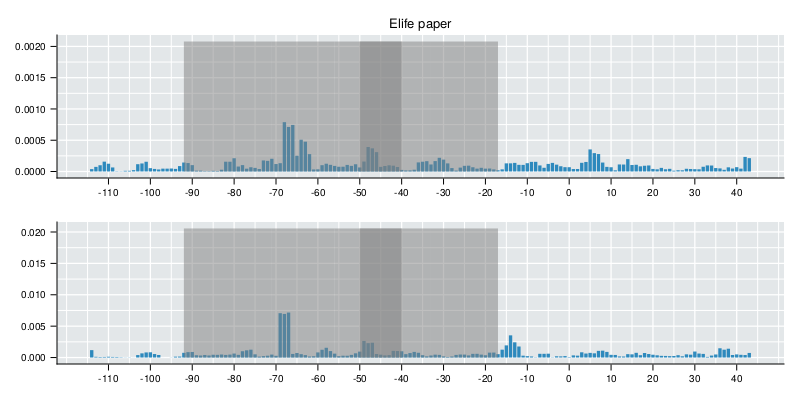

In [78]:
df = get_dataset(1)

df_elife = CSV.read("../../../data/regseq_elife/datasets/xylAM9dataset_alldone_with_large", DataFrame, ignorerepeated=true, delim=" ")
df_elife[!, "seq"] = [x[1:160] for x in df_elife.seq]
rename!(df_elife, :seq => :promoter)
insertcols!(df_elife, 4, :wt_seq => df_map[df_map.name .== "xylAp", :wt_seq][1])
x1 = wgregseq.footprints.mutual_information_mutation(df_elife)

fig = Figure(resolution=(800, 400))
ax1 = Axis(fig[1, 1], xticks=-110:10:40, title="Elife paper")
d = 1
barplot!(ax1, -115+d:44-d, [mean(x1[i-d:i+d]) for i in 1+d:160-d])

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "xylAp", :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== "xylAp", :])
    band!(ax1, [site["start"], site["end"]], [0, 0], [maximum(x1), maximum(x1)], color=("gray", 0.5))
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end
fig

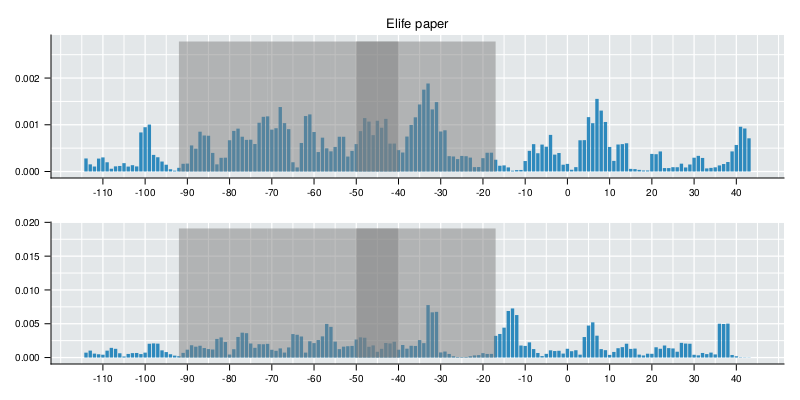

In [107]:
df = get_dataset(2)

df_elife = CSV.read("../../../data/regseq_elife/datasets/xylAxylaradataset_alldone_with_large", DataFrame, ignorerepeated=true, delim=" ")
df_elife[!, "seq"] = [x[1:160] for x in df_elife.seq]
rename!(df_elife, :seq => :promoter)
insertcols!(df_elife, 4, :wt_seq => df_map[df_map.name .== "xylAp", :wt_seq][1])
x1 = wgregseq.footprints.mutual_information_mutation(df_elife)

fig = Figure(resolution=(800, 400))
ax1 = Axis(fig[1, 1], xticks=-110:10:40, title="Elife paper")
d = 1
barplot!(ax1, -115+d:44-d, [mean(x1[i-d:i+d]) for i in 1+d:160-d])

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "xylAp", :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== "xylAp", :])
    band!(ax1, [site["start"], site["end"]], [0, 0], [maximum(x1), maximum(x1)], color=("gray", 0.5))
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end

fig

### xylF

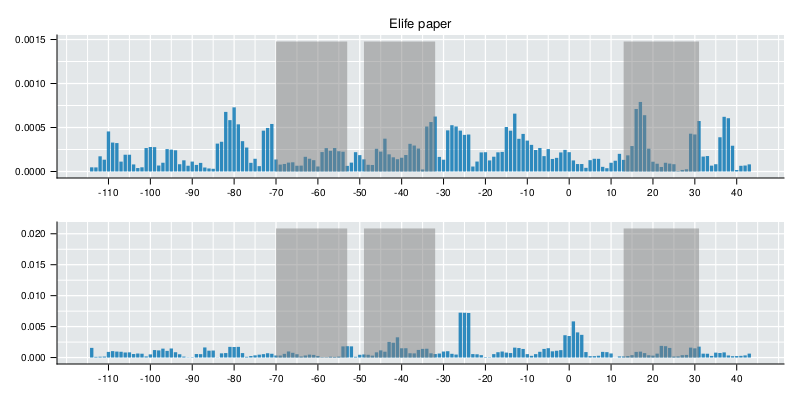

In [112]:
df = get_dataset(1)

df_elife = CSV.read("../../../data/regseq_elife/datasets/xylFM9dataset_alldone_with_large", DataFrame, ignorerepeated=true, delim=" ")
df_elife[!, "seq"] = [x[1:160] for x in df_elife.seq]
rename!(df_elife, :seq => :promoter)
insertcols!(df_elife, 4, :wt_seq => df_map[df_map.name .== "xylFp", :wt_seq][1])
x1 = wgregseq.footprints.mutual_information_mutation(df_elife)

fig = Figure(resolution=(800, 400))
ax1 = Axis(fig[1, 1], xticks=-110:10:40, title="Elife paper")
d = 1
barplot!(ax1, -115+d:44-d, [mean(x1[i-d:i+d]) for i in 1+d:160-d])

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "xylFp", :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== "xylFp", :])
    band!(ax1, [site["start"], site["end"]], [0, 0], [maximum(x1), maximum(x1)], color=("gray", 0.5))
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end

fig

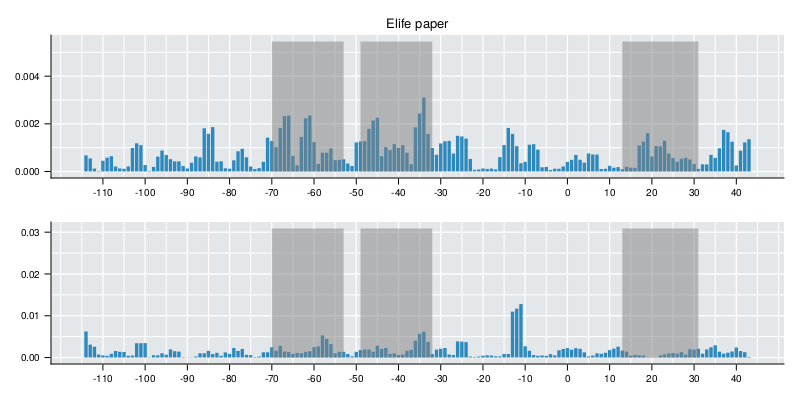

In [140]:
df = get_dataset(2)

df_elife = CSV.read("../../../data/regseq_elife/datasets/xylFxylaradataset_alldone_with_large", DataFrame, ignorerepeated=true, delim=" ")
df_elife[!, "seq"] = [x[1:160] for x in df_elife.seq]
rename!(df_elife, :seq => :promoter)
insertcols!(df_elife, 4, :wt_seq => df_map[df_map.name .== "xylFp", :wt_seq][1])
x1 = wgregseq.footprints.mutual_information_mutation(df_elife)

fig = Figure(resolution=(800, 400))
ax1 = Axis(fig[1, 1], xticks=-110:10:40, title="Elife paper")
d = 1
barplot!(ax1, -115+d:44-d, [mean(x1[i-d:i+d]) for i in 1+d:160-d])

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "xylFp", :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== "xylFp", :])
    band!(ax1, [site["start"], site["end"]], [0, 0], [maximum(x1), maximum(x1)], color=("gray", 0.5))
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end
fig

### dicCp

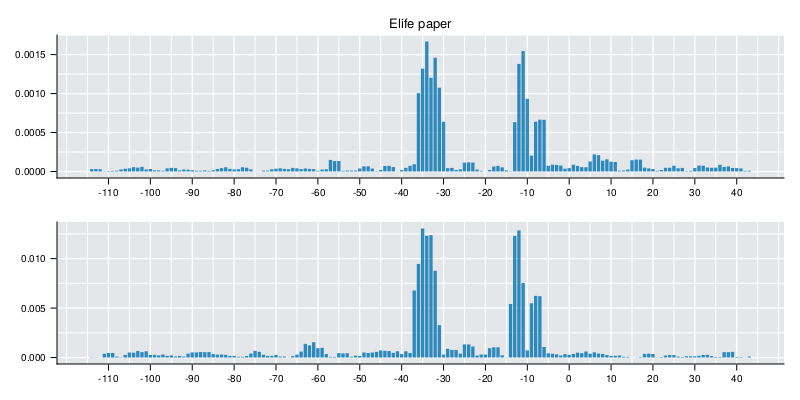

In [114]:
df = get_dataset(1)

df_elife = CSV.read("../../../data/regseq_elife/datasets/dicCM9dataset_alldone_with_large", DataFrame, ignorerepeated=true, delim=" ")
df_elife[!, "seq"] = [x[1:160] for x in df_elife.seq]
rename!(df_elife, :seq => :promoter)
insertcols!(df_elife, 4, :wt_seq => df_map[df_map.name .== "dicCp", :wt_seq][1])
x1 = wgregseq.footprints.mutual_information_mutation(df_elife)

fig = Figure(resolution=(800, 400))
ax1 = Axis(fig[1, 1], xticks=-110:10:40, title="Elife paper")
d = 1
barplot!(ax1, -115+d:44-d, [mean(x1[i-d:i+d]) for i in 1+d:160-d])

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "dicCp", :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== "dicCp", :])
    band!(ax1, [site["start"], site["end"]], [0, 0], [maximum(x1), maximum(x1)], color=("gray", 0.5))
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end

fig

### relB

In [1]:
df = get_dataset(1)

fig = Figure(resolution=(800, 200))
x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "relBp", :])
ax2 = Axis(fig[1, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== "relBp", :])
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end

fig

LoadError: UndefVarError: `get_dataset` not defined

### ftsKp1

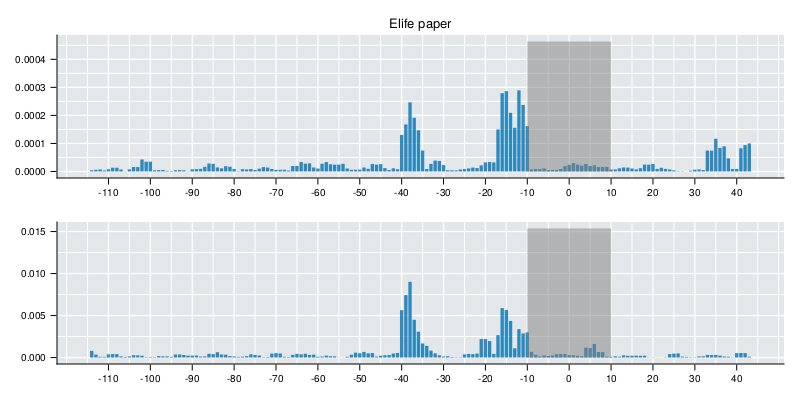

In [118]:
df = get_dataset(1)

df_elife = CSV.read("../../../data/regseq_elife/datasets/ftsKM9dataset_alldone_with_large", DataFrame, ignorerepeated=true, delim=" ")
df_elife[!, "seq"] = [x[1:160] for x in df_elife.seq]
rename!(df_elife, :seq => :promoter)
insertcols!(df_elife, 4, :wt_seq => df_map[df_map.name .== "ftsKp1", :wt_seq][1])
x1 = wgregseq.footprints.mutual_information_mutation(df_elife)

fig = Figure(resolution=(800, 400))
ax1 = Axis(fig[1, 1], xticks=-110:10:40, title="Elife paper")
d = 1
barplot!(ax1, -115+d:44-d, [mean(x1[i-d:i+d]) for i in 1+d:160-d])

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "ftsKp1", :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== "ftsKp1", :])
    band!(ax1, [site["start"], site["end"]], [0, 0], [maximum(x1), maximum(x1)], color=("gray", 0.5))
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end

fig

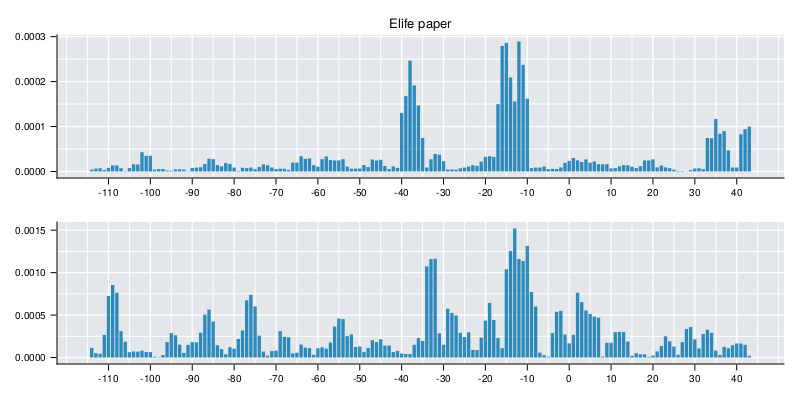

In [119]:
df = get_dataset(1)

df_elife = CSV.read("../../../data/regseq_elife/datasets/ftsKM9dataset_alldone_with_large", DataFrame, ignorerepeated=true, delim=" ")
df_elife[!, "seq"] = [x[1:160] for x in df_elife.seq]
rename!(df_elife, :seq => :promoter)
insertcols!(df_elife, 4, :wt_seq => df_map[df_map.name .== "ftsKp2", :wt_seq][1])
x1 = wgregseq.footprints.mutual_information_mutation(df_elife)

fig = Figure(resolution=(800, 400))
ax1 = Axis(fig[1, 1], xticks=-110:10:40, title="Elife paper")
d = 1
barplot!(ax1, -115+d:44-d, [mean(x1[i-d:i+d]) for i in 1+d:160-d])

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "ftsKp2", :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])
for site in eachrow(df_sites[df_sites.promoter .== "ftsKp2", :])
    band!(ax1, [site["start"], site["end"]], [0, 0], [maximum(x1), maximum(x1)], color=("gray", 0.5))
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end
fig

### marR

#### M9 Glucose

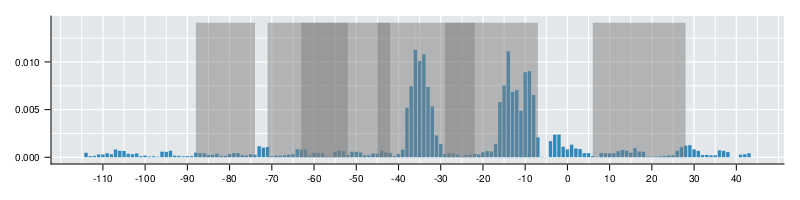

In [121]:
df = get_dataset(1)

fig = Figure(resolution=(800, 200))

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "marRp", :])
ax2 = Axis(fig[1, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== "marRp", :])
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end
fig

#### M9 Glucose + 2.5mM Sodium Salicylate

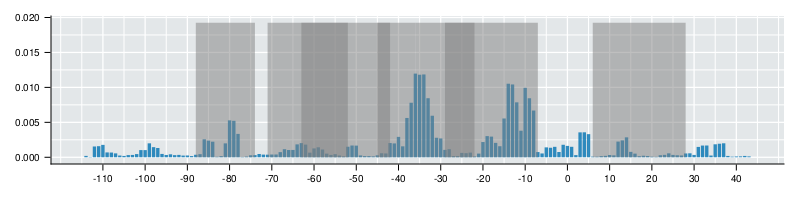

In [122]:
df = get_dataset(5)

fig = Figure(resolution=(800, 200))

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "marRp", :])
ax2 = Axis(fig[1, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== "marRp", :])
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end
fig

#### M9 Glucose + Ampicillin

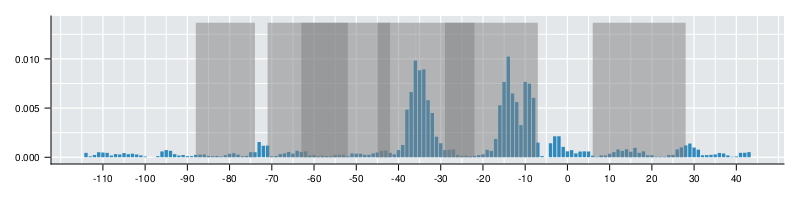

In [123]:
df = get_dataset(10)

fig = Figure(resolution=(800, 200))

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "marRp", :])
ax2 = Axis(fig[1, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== "marRp", :])
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end
fig

### dgoR

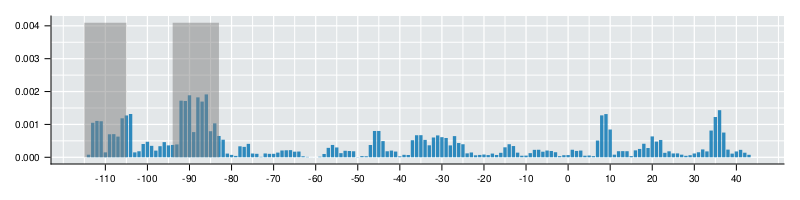

In [125]:
df = get_dataset(1)

fig = Figure(resolution=(800, 200))

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "dgoRp", :])
ax2 = Axis(fig[1, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])
for site in eachrow(df_sites[df_sites.promoter .== "dgoRp", :])
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end
fig

### araC

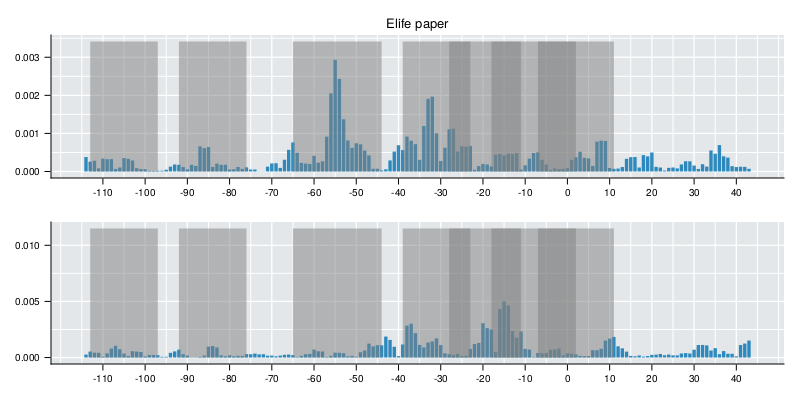

In [137]:
df = get_dataset(1)

df_elife = CSV.read("../../../data/regseq_elife/datasets/araCM9dataset_alldone_with_large", DataFrame, ignorerepeated=true, delim=" ")
df_elife[!, "seq"] = [x[1:160] for x in df_elife.seq]
rename!(df_elife, :seq => :promoter)
insertcols!(df_elife, 4, :wt_seq => df_map[df_map.name .== "araCp", :wt_seq][1])
x1 = wgregseq.footprints.mutual_information_mutation(df_elife)

fig = Figure(resolution=(800, 400))
ax1 = Axis(fig[1, 1], xticks=-110:10:40, title="Elife paper")
d = 1
barplot!(ax1, -115+d:44-d, [mean(x1[i-d:i+d]) for i in 1+d:160-d])

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "araCp", :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== "araCp", :])
    band!(ax1, [site["start"], site["end"]], [0, 0], [maximum(x1), maximum(x1)], color=("gray", 0.5))
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end

fig

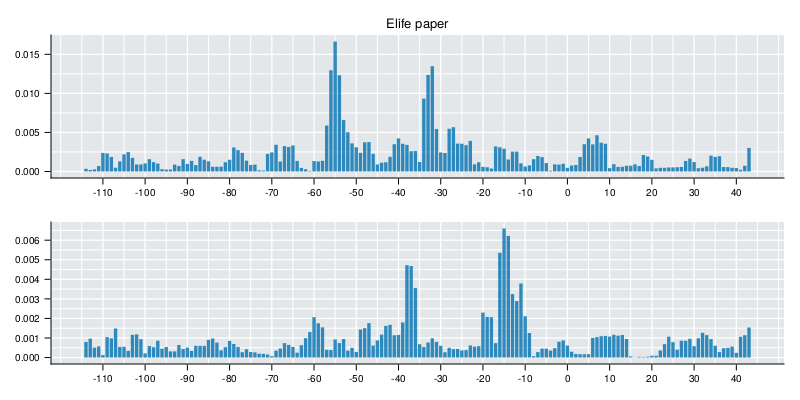

In [138]:
df = get_dataset(3)

df_elife = CSV.read("../../../data/regseq_elife/datasets/araCxylaradataset_alldone_with_large", DataFrame, ignorerepeated=true, delim=" ")
df_elife[!, "seq"] = [x[1:160] for x in df_elife.seq]
rename!(df_elife, :seq => :promoter)
insertcols!(df_elife, 4, :wt_seq => df_map[df_map.name .== "araCp", :wt_seq][1])
x1 = wgregseq.footprints.mutual_information_mutation(df_elife)

fig = Figure(resolution=(800, 400))
ax1 = Axis(fig[1, 1], xticks=-110:10:40, title="Elife paper")
d = 1
barplot!(ax1, -115+d:44-d, [mean(x1[i-d:i+d]) for i in 1+d:160-d])

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "araCp", :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

fig

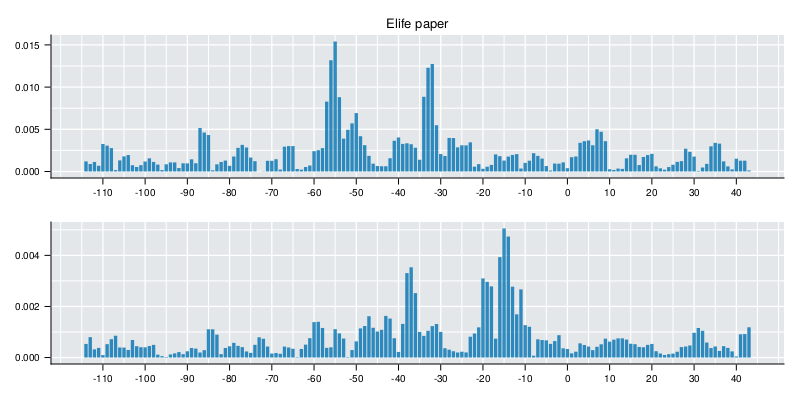

In [139]:
df = get_dataset(13)

df_elife = CSV.read("../../../data/regseq_elife/datasets/araCLBdataset_alldone_with_large", DataFrame, ignorerepeated=true, delim=" ")
df_elife[!, "seq"] = [x[1:160] for x in df_elife.seq]
rename!(df_elife, :seq => :promoter)
insertcols!(df_elife, 4, :wt_seq => df_map[df_map.name .== "araCp", :wt_seq][1])
x1 = wgregseq.footprints.mutual_information_mutation(df_elife)

fig = Figure(resolution=(800, 400))
ax1 = Axis(fig[1, 1], xticks=-110:10:40, title="Elife paper")
d = 1
barplot!(ax1, -115+d:44-d, [mean(x1[i-d:i+d]) for i in 1+d:160-d])

x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== "araCp", :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

fig

In [92]:
df.name |> unique

112-element Vector{String}:
 "TSS_1414_storz_regulondb"
 "TSS_18061_regulondb"
 "TSS_4654_wanner_regulondb"
 "TSS_4655_regulondb"
 "TSS_6311_regulondb"
 "aceBp"
 "acrAp"
 "acrBp"
 "acrZp"
 "araBp"
 "araCp"
 "blrp"
 "cpxRp2"
 ⋮
 "ygfKp"
 "ygfM_xdhD_predicted"
 "ygfS_ygfT_predicted"
 "ygiW_predicted"
 "yjbJ_predicted"
 "ykgRp"
 "ymfM_beeE_jayE_ymfL_ymfR_tfaP_ymfT_ymfN_ycfK_ymfQ_predicted"
 "yncEp"
 "yqaEp"
 "yqjE_yqjK_yqjD_yqjC_predicted"
 "zapB_predicted"
 "znuCp"

In [4]:
df_map = CSV.read(
    "../../../data/barcodes/20220514_mapping/mapped_barcodes.csv", 
    DataFrame, 
);

In [6]:
# Get twist order to get wild type sequences
df_seqs = wgregseq.utils.import_twist_order("../../../data/twist_orders/2022-02-15_twist_order.csv")
df_wt = df_seqs[1:1501:119*1501, :];
insertcols!(df_wt, 4, :promoter_seq => [string(x[27:186]) for x in df_wt.sequence])

df_wt.promoter_seq |> unique |> length
df_map = leftjoin(df_map, rename(df_wt[!, [:promoter, :promoter_seq]], :promoter => :name), on="name")
rename!(df_map, :promoter_seq => :wt_seq);


In [10]:
function expression_shifts(df)
    _df = copy(df) 
    # Compute relative (with pseudo counts)
    if :wt_seq ∉ names(_df)
        freq_mat = wgregseq.footprints.frequency_matrix(_df)[1]
        # find wild type sequence 
        wt_seq = argmax(freq_mat, dims=2) |> vec
        wt_seq = map(x -> x[2], wt_seq)
        wt_seq_dna = [wgregseq.footprints.DNA_dict_rev[x] for x in wt_seq]

        function is_mut(x)
            return x .!= wt_seq
        end

        insertcols!(_df, 4, :is_mutated => is_mut.(_df.int_promoter))
    else
        function is_mut(x, y)
            return x .!= y
        end
        insertcols!(_df, 4, :is_mutated => is_mut.(_df.int_promoter, df.int_wt))
    end

    mean_rel_counts = mean(_df.relative_counts)
    a = (_df.relative_counts .- mean_rel_counts) .* _df.is_mutated
    b = wgregseq.utils.onehot_encoder.(_df.promoter)

    ex_shift_arr = zeros(160, 4)
    for i in 1:nrow(_df)
        ex_shift_arr += a[i] .* b[i]
    end

    return ex_shift_arr ./ sum(b, dims=1)[1]
end

expression_shifts (generic function with 1 method)

In [11]:
i = 1

df_DNA = CSV.read(
    "../../../data/extracted_barcodes/20230907_barcode/D$(i)_collapsed.txt", 
    DataFrame, 
    ignorerepeated=true, 
    delim=" ", 
    header=["ct_0", "barcode"]
)
# import RNA
df_RNA = CSV.read(
    "../../../data/extracted_barcodes/20230907_barcode/R$(i)_collapsed.txt", 
    DataFrame, 
    ignorerepeated=true, 
    delim=" ", 
    header=["ct_1", "barcode"]
)

# merge DNA and RNA reads
df = outerjoin(df_DNA, df_RNA, on=:barcode)

# replace missing reads with 0
replace!(df.ct_0, missing => 0)
replace!(df.ct_1, missing => 0)

# identify promoter sequences
df = innerjoin(df, df_map, on=:barcode)

# compute total counts
insertcols!(df, 1, :ct => df.ct_0 .+ df.ct_1)
insertcols!(df, 1, :relative_counts => (df.ct_1 .+ 1) ./ (df.ct_0 .+ 1))

# Turn sequences into integer
insertcols!(df, 3, :int_promoter => wgregseq.footprints.make_int.(df[:, :promoter]))
insertcols!(df, 3, :int_wt => wgregseq.footprints.make_int.(df[:, :wt_seq]));

In [12]:
wt_seq = df_wt[df_wt.promoter .== "araBp", :promoter_seq][1]
ind_wt = collect(Iterators.product(collect(1:4), collect(wt_seq))) |> vec
# get mutual information
x = wgregseq.footprints.mutual_information_mutation(df[df.name .== "araBp", :])
# get expression shift
ex_shift = expression_shifts(df[df.name .== "araBp", :])
ex_shift ./= maximum(abs.(ex_shift))

160×4 Matrix{Float64}:
 -0.165683      0.0190596   0.0116475    0.0
  0.173721      0.0        -0.150683    -0.0294333
  0.0262966     0.0        -0.00116244   0.127616
  0.0           0.050076   -0.0989496   -0.0222973
 -0.000574055   0.0        -0.123455    -0.0508272
  0.0          -0.0997217   0.060639    -0.0476991
  0.148169     -0.0723614  -0.030608     0.0
  0.0225918    -0.035271    0.367926     0.0
  0.0268908    -0.183708    0.0          0.0763181
  0.0           0.15366    -0.139773    -0.102537
  0.0373626     0.0140613   0.0828874    0.0
  0.0212964     0.0359332  -0.0195785    0.0
  0.0          -0.0212045   0.0623207    0.10862
  ⋮                                     
  0.0353729    -0.0692488  -0.0290101    0.0
  0.0409541     0.0039344  -0.0864259    0.0
 -0.25614      -0.0526495   0.0          0.0646682
  0.0813174     0.0         0.192794    -0.0968112
  0.0          -0.119196   -0.0452326   -0.0970888
  0.0           0.211283    0.0362532    0.031836
  0.513701    

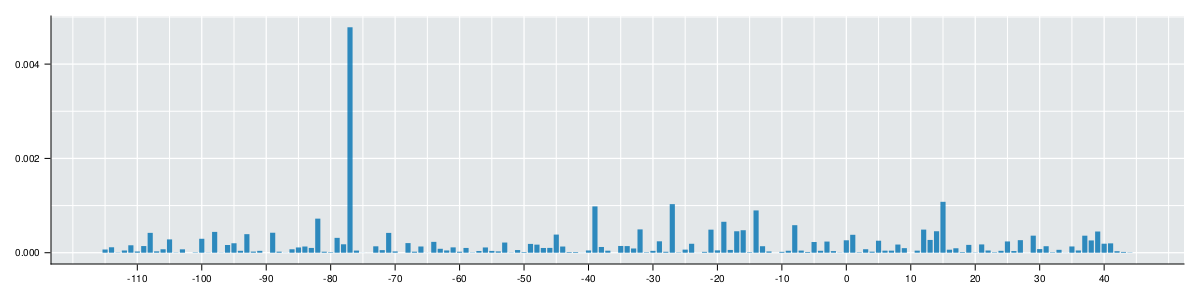

In [15]:
fig = Figure(resolution=(1200, 300))
ax = Axis(fig[1, 1], xticks=-110:10:40)

barplot!(ax, -115:44, x)

fig

In [18]:
x[-76+115]

0.004781016492982352

In [ ]:
CSV.read("../../../data/")